In [1]:
import numpy as np 
import pandas as pd 




In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

In [5]:
df = pd.read_csv(r"fer2013.csv")
df.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [14]:
df.shape

(35887, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [8]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))

In [9]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest' or row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

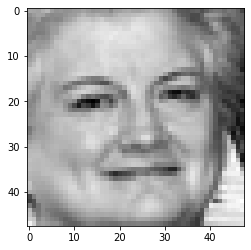

In [10]:
plt.imshow(np.array(X_train[100], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')

In [11]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [12]:
X_train.shape

(28709, 2304)

In [13]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)



In [12]:
y_train.shape

(28709,)

In [14]:
print(X_test[[0]])
print(y_test[0])

[[[[254]
   [254]
   [254]
   ...
   [ 16]
   [  0]
   [161]]

  [[254]
   [254]
   [254]
   ...
   [ 17]
   [  0]
   [122]]

  [[254]
   [254]
   [254]
   ...
   [ 26]
   [  0]
   [114]]

  ...

  [[ 66]
   [ 86]
   [ 99]
   ...
   [255]
   [252]
   [254]]

  [[ 84]
   [ 92]
   [ 92]
   ...
   [236]
   [255]
   [255]]

  [[ 93]
   [ 90]
   [ 85]
   ...
   [ 42]
   [129]
   [180]]]]
0


In [13]:
import keras
from keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [24]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64



In [25]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

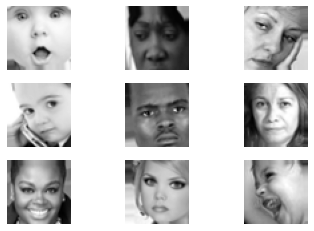

In [26]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

In [27]:
from keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.models import Sequential

In [28]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merging import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [29]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

     #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [30]:
model = FER_Model()
opt = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

In [31]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [33]:

num_epochs = 25  
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    validation_data=test_flow,  
                    validation_steps=len(X_test) / batch_size)

C:\Users\mohib\AppData\Local\Temp\ipykernel_3536\1096493519.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,


Epoch 1/25

Epoch 1: val_loss improved from inf to 1.93556, saving model to weights_min_loss.hdf5
448/448 - 1451s - loss: 2.0146 - accuracy: 0.2150 - val_loss: 1.9356 - val_accuracy: 0.2441 - 1451s/epoch - 3s/step
Epoch 2/25

Epoch 2: val_loss improved from 1.93556 to 1.84145, saving model to weights_min_loss.hdf5
448/448 - 1294s - loss: 1.7773 - accuracy: 0.2608 - val_loss: 1.8414 - val_accuracy: 0.2697 - 1294s/epoch - 3s/step
Epoch 3/25

Epoch 3: val_loss improved from 1.84145 to 1.76384, saving model to weights_min_loss.hdf5
448/448 - 1269s - loss: 1.7311 - accuracy: 0.2960 - val_loss: 1.7638 - val_accuracy: 0.3222 - 1269s/epoch - 3s/step
Epoch 4/25

Epoch 4: val_loss improved from 1.76384 to 1.70738, saving model to weights_min_loss.hdf5
448/448 - 1330s - loss: 1.6734 - accuracy: 0.3316 - val_loss: 1.7074 - val_accuracy: 0.3621 - 1330s/epoch - 3s/step
Epoch 5/25

Epoch 5: val_loss improved from 1.70738 to 1.65980, saving model to weights_min_loss.hdf5
448/448 - 1333s - loss: 1.6006

<Figure size 432x288 with 0 Axes>

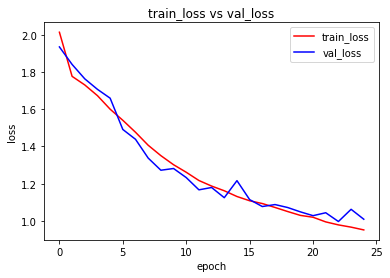

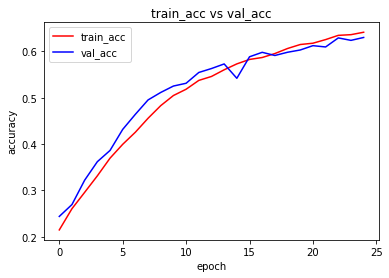

<Figure size 432x288 with 0 Axes>

In [34]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [38]:
model.save('../working/Fer2013.h5')

In [39]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

225/225 [==============================] - 41s 181ms/step - loss: 1.0087 - accuracy: 0.6300
Test Loss 1.0087312459945679
Test Acc: 0.6299805045127869


225/225 [==============================] - 46s 204ms/step


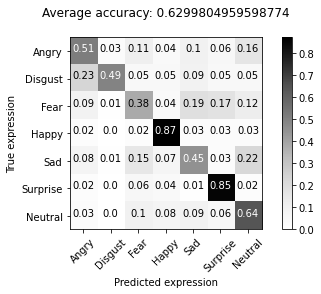

In [40]:
import itertools
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [9]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

NameError: name 'model' is not defined

In [15]:
from keras.models import model_from_json
model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')

In [16]:
print(X_test.shape)
print(y_test.shape)

(7178, 48, 48, 1)
(7178,)


In [17]:
print(X_test[0])
print(y_test[0])

[[[254]
  [254]
  [254]
  ...
  [ 16]
  [  0]
  [161]]

 [[254]
  [254]
  [254]
  ...
  [ 17]
  [  0]
  [122]]

 [[254]
  [254]
  [254]
  ...
  [ 26]
  [  0]
  [114]]

 ...

 [[ 66]
  [ 86]
  [ 99]
  ...
  [255]
  [252]
  [254]]

 [[ 84]
  [ 92]
  [ 92]
  ...
  [236]
  [255]
  [255]]

 [[ 93]
  [ 90]
  [ 85]
  ...
  [ 42]
  [129]
  [180]]]
0


1/1 [==============================] - 1s 722ms/step
actual Disgust
predicted:  Fear


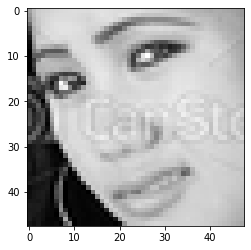

In [18]:
def get_prediction(j):
    index=model.predict(X_test[j].reshape(1,48,48,1))
    label=classes[int(index.argmax())]
    print("actual",classes[y_test[j]])
    print("predicted: ",label)
    plt.imshow(X_test[j].reshape(48,48),cmap='gray')
get_prediction(1)



In [18]:
import cv2
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [19]:
import os
import cv2
import numpy as np
from keras.models import load_model, model_from_json
from keras.utils import load_img,img_to_array
from keras.preprocessing import image
model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')
# model = load_model('static\Fer2013.h5')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap=cv2.VideoCapture(0)


#eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

while cap.isOpened():
    res,frame=cap.read()

    height, width , channel = frame.shape
    sub_img = frame[0:int(height/6),0:int(width)]

    black_rect = np.ones(sub_img.shape, dtype=np.uint8)*0
    res = cv2.addWeighted(sub_img, 0.77, black_rect,0.23, 0)
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    FONT_SCALE = 0.8
    FONT_THICKNESS = 2
    lable_color = (10, 10, 255)
    lable = "Facial Expression Recognition"
    lable_dimension = cv2.getTextSize(lable,FONT ,FONT_SCALE,FONT_THICKNESS)[0]
    textX = int((res.shape[1] - lable_dimension[0]) / 2)
    textY = int((res.shape[0] + lable_dimension[1]) / 2)
    cv2.putText(res, lable, (textX,textY), FONT, FONT_SCALE, (0,0,0), FONT_THICKNESS)
    gray_image= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image )
    try:
        for (x,y, w, h) in faces:
            cv2.rectangle(frame, pt1 = (x,y),pt2 = (x+w, y+h), color = (255,0,0),thickness =  2)
            roi_gray = gray_image[y-5:y+h+5,x-5:x+w+5]
            roi_gray=cv2.resize(roi_gray,(48,48))
            image_pixels = img_to_array(roi_gray)
            image_pixels = np.expand_dims(image_pixels, axis = 0)
            image_pixels /= 255
            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]
            cv2.putText(res, "Expression: {}".format(emotion_prediction), (0,textY+22+5), FONT,0.7, lable_color,2)
            lable_violation = 'Accuracy: {}'.format(str(np.round(np.max(predictions[0])*100,1))+ "%")
            violation_text_dimension = cv2.getTextSize(lable_violation,FONT,FONT_SCALE,FONT_THICKNESS )[0]
            violation_x_axis = int(res.shape[1]- violation_text_dimension[0])
            cv2.putText(res, lable_violation, (violation_x_axis,textY+22+5), FONT,0.7, lable_color,2)
    except :
        pass
    frame[0:int(height/6),0:int(width)] =res
    cv2.imshow('frame', frame)


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break



cap.release()
cv2.destroyAllWindows


1/1 [==============================] - 0s 73ms/step


<function destroyAllWindows>